In [145]:
#Import dependencies
import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Required Functions ###

In [146]:
#BPSK Modulation
def bpsk_mod(mu,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=mu, up = L) # NRZ encoder; upfirdn: Upsample, FIR filter, and downsample.
    t=np.arange(start = 0,stop = len(mu)*L) #discrete time base
    return (s_bb,t)

#BPSK demodulation        
def bpsk_demod(r_bb,L):
    x = np.real(r_bb) # I arm
    x = np.convolve(x,np.ones(L)) # integrate for Tb duration (L samples)
    x = x[L-1:-1:L] # I arm - sample at every L
    ak_hat = (x > 0).transpose() # threshold detector
    return ak_hat

#Noise (AP to BD)
def noise(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    #r = s + n # received signal
    return n

#Noise (BD to AP)
def awgn(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal #AWGN channel
    return r

# In theoretical analyses and simulations, for AWGN, the channel gain ℎ is often considered as a complex Gaussian random variable 
# with unity magnitude (i.e.,|ℎ∣=1) and uniformly distributed phase between 0 and 2π. This assumption simplifies 
# the analysis and is a common model used in communication theory to characterize the effects of the channel.

### More Required Functions ###

In [147]:
#Pathloss Model - Log distance
def logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n):
    #Pt_dBm = Transmitted power in dBm
    #G_BD_dBi = Gain of the BD antenna in dBi
    #G_AP_dBi = Gain of the AP antenna in dBi
    #f = frequency of transmitted signal in Hertz
    #d0 = reference distance of receiver from the transmitter in meters
    #d = array of distances at which the loss needs to be calculated
    #L = Other System Losses, for no Loss case L=1
    #sigma = Standard deviation of log Normal distribution (in dB)
    #n = path loss exponent
    #Pr_dBm = Received power in dBm
    #PL = path loss due to log normal shadowing
    lamda_ = (3*10**8)/f #Wavelength in meters
    K = 20*math.log10((4*np.pi*d0)/lamda_) # Path Loss factor *******- 10*n*math.log10(d0) - 10*math.log10(L) #path-loss factor
    X = sigma*np.random.randn() #normal random variable
    PL_dB = Gt_dBi + Gr_dBi + K + 10*n*math.log10(d/d0) + X  #PL(d) including antennas gains
    
    #Pr_dBm = Pt_dBm + PL #Receieved power in dBm at d meters
    return PL_dB


#AP-BD Channel Gain
def APBD_ChannelGain(f):
    Pt_dBm = 30 #1W AP transmission power 1W = 30dBm
    Gt_dBi = 1 #Gain of the AP antenna in dBi 
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 3 #distance between AP and BD #Throughput reduces significantly after 4 meters ()
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-AP Channel Gain
def JAP_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-BD Channel Gain
def JBD_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#Loopback Channel Gain (SIC)
def loopback_Channel():
    epsilon = 1e-10 #very small number
    Pt_dBm = 30 #should be same as AP transmission power
    #g_hat: feedback channel coefficient
    #g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
    #g_tilde = 6e-5#g_tilde: estimation error
    #g_hat = g_bar + (sqrt(epsilon))*g_tilde 
    G = 1 #E[g_tilde**2]=1
    sigma = np.random.normal(loc=0.0, scale=1.0, size=None)
    phi = -20 #dBm 30dBm reduction = 60dB reduction, by current techniques, it has been reported that SI can be canceled up to −81 dB in analog domain
    combined_power_dB = (Pt_dBm+phi) + sigma**2
    combined_power = 10**(combined_power_dB/10)
    P = combined_power*epsilon*G
    return P

#print('X of APBD', APBD_ChannelGain(900e6)) #changing "logNormalShadowing" function to return X
#print('X of JBD', JBD_ChannelGain(900e6)) #changing "logNormalShadowing" function to return X
#print('X of JAP', JAP_ChannelGain(900e6)) #changing "logNormalShadowing" function to return X

#Comment: X follows same distribution for all channels (H,JAP,JBD), but X for each are different. Also, X changes in each time slot


### System Parameters ###

In [148]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period) Tb (bit period) = symbol duration = (1/900MHz) = 1.1ns
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency
#Backscatter Reflection Coefficient - when the tag wants to transmits a 1, it reflects and absorbs when it wants to transmit a 0
mu = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband

In [149]:
print(s_bb)

[1. 1. 1. ... 0. 0. 0.]


#### AP and Jammer Signal ####

In [150]:
### numpy.random.randn => Return a sample (or samples) from the “standard normal” distribution. 
#[Recall: The standard normal distribution is a specific type of normal distribution where the mean is equal to 0 
#and the standard deviation is equal to 1.]
### numpy.random.normal => Draw random samples from a normal (Gaussian) distribution. 

x = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)
x_J = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)

### Noise ###

In [151]:
#random.normal(loc=0.0, scale=1.0, size=None); loc => mean, scale => Standard deviation of the distribution (must be non-negative
def complex_noise(mean, variance, size):
    # Generate real and imaginary parts separately with normal distribution
    real_part = np.random.normal(mean, np.sqrt(variance), size)
    imag_part = np.random.normal(mean, np.sqrt(variance), size)
    
    # Combine real and imaginary parts into complex numbers
    complex_noise = real_part + 1j * imag_part
    
    return complex_noise
#complex_noise = complex_noise(0, 1, N*L) # Mean = 0, Variance = 1, Size = N*L

### Jammer Strategy ###

In [181]:
def Jammer(n):
    M = 5 #Jammer power level upper limit
    P_J = 10 # np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
    #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
    deltaf = 10e6 #frequency step
    Fc = 900e6 #900MHz #base carrier frequency
    seq = [0,1]
    n = n+1
    if n == len(seq):
        n = 0
    k_J = seq[n]
    #print(n)
    f_J = Fc + (k_J*deltaf)  #Jammer staying only on one channel
    return (P_J,f_J,n)

In [182]:
## Mean Jamming Power Received at AP ##
def Mean_Received_Jam_Power(P_J,f_J):
    Gt_dBi = 18 #Gain of the J antenna in dBi 
    Gr_dBi = 12 #Gain of the AP antenna in dBi
    lambda_ = (3*10**8)/(f_J)
    d = 2 #distance between J and AP or J and BD
    n=2 # path loss exponent
    PR_J = P_J*((Gt_dBi*Gr_dBi*(lambda_**2))/((d**n)*(4*np.pi)**2)) # in Watt
    return PR_J 

### State Space, Action Space ###

In [183]:
#State:
#AP can choose 4 channels, AP_state = [0,1,2,3]
#Jammer can be present or absent in the current channel, jammer_state = [0,1]

#Action:
#Action space is denoted by AP jumping into a channel, action_space = [0,1,2,3]

In [184]:
# Define AP_state and jammer_state
AP_state = [0, 1]
jammer_state = [0, 1]
# Define the action_space
action_space = [0, 1]

state_space = np.array(np.meshgrid(AP_state, jammer_state)).T.reshape(-1, 2)
print('State Space: \n',state_space)
q_table = np.zeros((len(AP_state),len(jammer_state),len(action_space)))
print('\nQ-table: \n',q_table)

### for debugging

# q_table_int = np.random.randint(low = 1, high = 100, size=(len(AP_state),len(jammer_state),len(action_space)), dtype=int)
# print(q_table_int)
# print(np.shape(q_table_int))
# test = q_table_int[0,0,:] #cell_num,row_num,col_num #max_cell_num = 3,max_row_num = 1,max_col_num = 3
# print(test)

State Space: 
 [[0 0]
 [0 1]
 [1 0]
 [1 1]]

Q-table: 
 [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]


### Trainning Phase

In [185]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = 400 #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot

In [186]:
#training parameters
#In this case, number of steps per episode = number of time slots per episode
#No terminating condition - each episode run up to "nSteps" - time slots

num_episodes = 200 #total no. of episodes the agent will play during training
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.1 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge
discount_rate = 0.99 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

In [191]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps = []
avg_reward_all_episodes = []
#rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode,dtype='float32')
P_R_AP = np.zeros(max_steps_per_episode,dtype='float32')
P_N = np.zeros(max_steps_per_episode,dtype='float32')
SNR = np.zeros(max_steps_per_episode,dtype='float32')

n= -1

# Q-learning algorithm
for episode in range(num_episodes):
    current_state = 0
    epochs += 1
    rewards_current_step = 0
    rewards_each_episode = []
    #avg_reward = 0
    for step in range(max_steps_per_episode):
        iterations += 1
        # Exploration-exploitation trade-off
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[current_cell][current_row][:]) #gives the index of the column with highest Q-value corresponding to row = current_state
            #print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
            #print('Random Action: ',action)
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        P_T = 1 #AP transmission power: 1W
        
        #Jammer Strategy:
        (P_J,f_J,n) = Jammer(n) 

        P_R = ((s_bb**2)*P_T*APBD_ChannelGain(f_k)) #+ ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*JBD_ChannelGain(f_J)) + P_J*JAP_ChannelGain(f_J) + loopback_Channel() + abs(complex_noise(0, 1, N*L))

        P_R_AP[step] = sum(P_R)/(N*L); SNR11=15; P_R_APP=sum(P_R)/(N*L);
        N_variance=P_R_APP/10**(SNR11/10);

        unwanted_signal = 1*(f_J==f_k)*Mean_Received_Jam_Power(P_J,f_J) + loopback_Channel() + N_variance*abs(complex_noise(0, 1, N*L))


        P_N[step] = sum(unwanted_signal)/(N*L)

        SNR[step] =  P_R_AP[step]/P_N[step]
        #print(SNR)
        reward[step] = math.log2(1+SNR[step]) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
        #print(reward)
        
        #### Training ####
        
        if(f_J == f_k):
            current_row = 1
        else:
            current_row = 0
        
        current_cell = current_state
        
#         current_cell = which channel AP is in for current step
#         current_row = jammer present or absent in current channel
#         action = which channel AP jumped to for next step
        #next state
        new_cell = action

        # Update Q-table for Q(s,a)
        q_table[current_cell,current_row, action] = q_table[current_cell,current_row, action] * (1 - learning_rate) + \
        learning_rate * (reward[step] + discount_rate * np.max(q_table[new_cell,current_row,:]))
        # Transition to the next state
        current_state = new_cell

        print(reward[step])
        # Add new reward
        rewards_current_step = reward[step]
        rewards_each_episode.append(rewards_current_step)
        rewards_all_steps.append(rewards_current_step)
        all_iterations.append(iterations)
        
    avg_reward = sum(rewards_each_episode)/max_steps_per_episode
    avg_reward_all_episodes.append(avg_reward)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)


4.710987
0.00017846539
4.709938
4.7072506
8.452863e-05
4.711465
4.7113857
0.00011217895
4.710726
4.71088
9.2337075e-05
4.710166
4.7101607
0.000115008006
4.709077
4.7171297
7.4918884e-05
4.7079306
4.7098565
0.000113721835
4.710464
4.7120256
0.00011685405
4.7151875
4.7153435
6.3310305e-05
4.7091184
4.7124367
0.00016891323
4.708633
4.712215
9.741419e-05
4.713496
4.7151284
0.00015983757
4.713684
4.712152
8.1476035e-05
4.7126455
4.713001
0.00012597592
4.7140417
4.708869
8.3213505e-05
4.712814
4.7135854
8.488152e-05
4.70952
4.71552
5.8326044e-05
4.711606
0.00010078123
4.7115355
4.7132354
6.5298744e-05
4.7105274
4.7131867
0.00011338234
4.7116933
4.7075753
8.472347e-05
4.7076564
4.7127275
0.00010400595
4.7099533
4.710955
5.371975e-05
0.000101508514
4.711016
4.7095637
0.000115464936
7.007805e-05
5.5209635e-05
0.00012583841
4.7130423
4.71056
9.9261415e-05
0.00013439062
4.7088876
4.710629
0.00022894912
0.00012397396
6.199665e-05
0.00014514578
7.456961e-05
0.00011896956
4.7121844
4.709643
7.935465

0.0001633577
0.0001899734
9.383769e-05
4.709862
0.00012263848
0.00012546386
0.00016882093
4.705958
0.00014573616
4.7109385
4.7097096
0.000105734856
7.92197e-05
4.710259
4.7102036
7.589993e-05
4.7080173
0.00020919304
4.711816
4.710275
4.7121325
0.00010181336
4.7060194
0.00013054188
4.712199
7.941418e-05
4.7056046
4.7132597
0.00011430692
6.3417065e-05
4.8543014e-05
4.7097135
4.7087846
4.7093935
0.00013183488
4.7154584
4.7135925
4.709283
4.7099404
0.000113897615
7.7734e-05
4.715615
4.710809
4.711145
4.827406e-05
8.647216e-05
6.022578e-05
5.2865693e-05
6.7896624e-05
4.712371
9.4881274e-05
5.2970383e-05
4.7108827
4.7112403
0.00013319265
4.7107053
4.708886
4.712775
0.00016215339
4.710825
4.711843
6.2699946e-05
0.00010058546
0.0001712997
4.712726
7.191299e-05
7.979223e-05
7.199697e-05
7.81467e-05
4.7097507
6.904326e-05
0.00015457785
0.00011672919
4.7132683
0.00022098866
4.71076
4.711537
0.00011934695
9.5299685e-05
4.7120404
4.7142477
4.709474
0.0001428179
4.715653
4.7066946
4.713427
4.1567357

9.240646e-05
5.9832688e-05
4.7093735
9.530281e-05
4.713506
0.00016922828
2.8140184e-05
4.708789
7.3927964e-05
0.00011350742
0.00014633698
4.7108736
4.877692e-05
4.710875
4.7091904
4.713526
4.71117
4.712223
9.471868e-05
0.0001076302
0.00022360828
0.00012380799
4.7122765
4.7077365
4.709274
0.00014535345
5.9482434e-05
4.707802
0.00010985
4.713019
0.00012852934
0.00021855618
4.71336
5.1905718e-05
4.711228
0.00011975628
4.712291
4.712571
4.710878
6.121368e-05
4.712473
5.8316364e-05
4.7136354
8.561362e-05
4.7096605
0.00010661698
9.211041e-05
0.00011094638
7.1721835e-05
0.00010872839
9.749699e-05
4.7165647
4.7091327
4.7124767
4.709929
4.8290643e-05
4.711358
5.8760634e-05
0.00010189818
4.708112
4.7113204
4.7077327
4.7103252
4.7123637
4.708242
7.988286e-05
4.7096987
9.416737e-05
4.218215e-05
4.710976
5.821005e-05
4.7109995
6.686611e-05
4.7096357
0.00017637099
4.714637
4.710853
7.976216e-05
0.00015345927
0.00019656475
4.712394
4.7095284
5.1998075e-05
0.000121986
4.706954
6.578525e-05
6.663964e-0

4.712554
4.709116
0.00010091511
0.00015132579
4.7110295
4.71022
0.000111749076
8.472556e-05
3.334383e-05
4.7103868
4.7077966
4.7111816
8.020554e-05
4.7090774
4.7104445
4.7080007
5.6807683e-05
0.00014196172
0.00016619649
9.756471e-05
8.2705745e-05
4.707211
4.5515677e-05
7.611138e-05
4.713302
6.6515444e-05
9.998976e-05
4.712891
4.711245
4.711958
0.00017013366
4.7116265
4.7077904
4.71205
0.00016048475
4.710848
4.711728
0.00012775633
8.315945e-05
7.2470066e-05
0.00013062768
4.711169
0.00018703454
4.7084227
0.00022366706
4.707573
4.7133164
4.710799
5.646349e-05
4.710887
4.7052007
4.710668
4.7085333
4.7101655
4.710551
0.00014040775
0.00016767881
0.00010069057
4.712539
4.7118807
0.00011305721
4.709758
0.00014420411
4.714988
9.225012e-05
0.00011913993
0.0001915765
0.00011231484
0.00011059429
8.672564e-05
4.7113853
4.7142916
7.654995e-05
0.00011068007
4.710369
4.713694
0.00011261238
5.1337476e-05
4.7076755
7.6136566e-05
4.7053056
0.0001434053
9.539316e-05
0.00010420805
0.00020527348
4.7114053
5

0.00010511541
4.712346
6.440302e-05
4.7112255
8.735372e-05
4.705746
5.7872152e-05
0.00014337598
4.7103505
0.00010430289
8.456378e-05
4.71495
4.711826
4.712149
0.00014723786
4.688107e-05
0.00015511096
4.7134132
4.7125764
4.709546
8.2956474e-05
7.512988e-05
6.296491e-05
4.711947
5.73657e-05
4.7124944
0.000111982066
4.7072463
0.00017452176
5.954651e-05
4.7120385
8.797214e-05
7.2335926e-05
4.7090693
4.711543
4.711129
0.0001220525
4.710611
7.873408e-05
8.577172e-05
4.711243
5.2685515e-05
4.707554
6.342774e-05
9.722829e-05
0.00011487705
7.153811e-05
7.403608e-05
4.7124147
4.711792
0.00016194275
4.710357
4.715797
4.7096314
4.7156386
4.71094
7.751762e-05
4.7142315
4.7073817
9.637433e-05
4.6669604e-05
7.8247635e-05
6.7527944e-05
0.00015018045
4.7112675
0.00011562725
8.078493e-05
4.7133226
4.71103
4.7125535
0.00024750808
5.4768367e-05
7.663701e-05
4.7117395
4.716613
4.7127385
0.00015027035
4.7146716
4.708481
0.00010208629
0.000102284444
4.709721
0.00010806343
4.70852
7.7563695e-05
9.332545e-05
4

0.00010028108
4.7080584
5.0832285e-05
4.7114544
7.952084e-05
4.7107453
8.3977066e-05
4.7134423
4.7100625
4.710786
4.706927
4.714932
0.00019531719
4.709715
4.710281
4.709354
4.7127204
4.709198
0.00011891399
4.707003
4.711604
7.317708e-05
4.7143116
0.00015430937
4.713913
7.991237e-05
4.711072
4.714949
8.821037e-05
4.710691
4.1148203e-05
4.741113e-05
4.0332343e-05
0.00014469268
0.00013261044
6.027002e-05
5.9799382e-05
4.7112303
0.00017900122
0.0001358705
4.7109094
4.715914
8.4958905e-05
0.00013014079
6.1783896e-05
0.00012654017
4.709268
4.710514
0.00012655792
4.710232
4.712054
4.7103386
6.537913e-05
0.00015448782
0.0001322748
4.7124043
4.711182
4.7132306
4.71044
5.1033836e-05
4.5468907e-05
4.7114673
8.331744e-05
0.000109946406
4.711969
4.7097106
5.4985147e-05
4.7123365
0.0001110626
4.7082586
9.058616e-05
8.8267436e-05
4.712016
6.9001755e-05
4.7144966
4.708347
4.709982
5.0035058e-05
4.711899
5.0684004e-05
4.712257
4.2517244e-05
9.750419e-05
0.00016710028
4.710274
0.00016811605
4.714258
6.3

8.917739e-05
0.00012589757
8.5361375e-05
4.709887
4.7123604
4.711055
4.712744
4.7127986
0.00022628118
0.00017550866
4.709008
0.00011091313
9.5996336e-05
4.7127023
4.7131157
6.0315273e-05
4.708494
0.00010335477
6.7604946e-05
0.00013093452
3.7637266e-05
4.7104177
4.7912952e-05
7.05028e-05
4.711193
0.00013173935
4.709344
0.000109521345
4.7121344
0.00012902227
0.00012266137
0.000101433965
4.7082787
0.00023469012
0.00010973038
4.7092257
4.7133217
4.7093763
4.891087e-05
0.00011346883
4.7080374
9.627686e-05
4.7103195
0.00013142385
4.7127438
4.709104
8.599024e-05
9.1573806e-05
4.7121787
4.710309
6.916272e-05
4.712613
4.711345
6.9741145e-05
4.711106
0.00010184788
4.7112803
0.00015014554
4.7088084
8.9756744e-05
4.708716
4.712644
4.7131233
4.7130866
4.7154956
4.7055426
9.743662e-05
4.709548
4.713357
0.000113340866
4.71349
7.2655836e-05
0.000112505324
7.906514e-05
6.863689e-05
6.741664e-05
4.712791
4.711685
4.709771
4.710084
0.00019264904
0.00011124244
4.7101665
4.70943
0.00012818997
4.7123346
4.7

0.000121449426
4.7099624
4.709432
0.00012956646
4.71072
4.709973
8.9855785e-05
4.711047
0.0001073859
5.7860107e-05
6.359581e-05
4.7114897
4.7086716
0.00012563991
4.8551276e-05
4.7098036
5.631156e-05
4.714348
0.0001530863
4.70726
4.7103906
3.159079e-05
4.713203
4.713381
0.00022627217
0.00013007424
0.00012243573
4.709579
7.500456e-05
4.713131
4.7112255
4.711197
4.7101636
5.5997196e-05
4.7109823
4.7104406
0.0001393117
0.0001062273
0.000104263265
0.00027487677
4.712475
7.8963894e-05
9.133981e-05
4.710464
0.00021661975
4.712318
6.062571e-05
4.709714
0.00012348416
4.7153034
4.710353
4.7100067
4.7109113
4.710867
4.711379
4.7135835
4.7119827
2.6617741e-05
8.327903e-05
5.2479954e-05
4.712158
4.7085314
4.710951
4.7152934
6.461798e-05
0.00016309482
4.709186
4.7112327
4.7115583
4.713087
4.710045
9.8253404e-05
8.0349935e-05
4.708235
0.00019068403
4.681807
4.7109404
4.711643
4.709178
4.709503
4.7100153
9.670354e-05
0.000121162484
0.0001121817
0.00015553406
4.711393
4.7156587
4.712411
4.711696
0.0001

4.7117524
4.7114506
4.704041
4.6117984e-05
9.722482e-05
0.00018335966
4.7059464
7.6989156e-05
4.712893
4.7095056
1.911354e-05
9.732777e-05
5.3617834e-05
4.7108545
4.714378
4.708921
4.7094274
6.885252e-05
4.7090125
0.0001453414
8.3202496e-05
4.7134275
4.8741378e-05
9.946984e-05
8.856897e-05
4.708926
8.105179e-05
4.7097545
4.710046
8.2525985e-05
4.7136464
4.7130704
4.707361
0.00014433321
0.00010179692
4.715431
0.00018899304
4.7133026
4.712221
0.0001332
0.00021411388
3.7559115e-05
9.5917625e-05
3.9173505e-05
8.1057e-05
8.660358e-05
9.118783e-05
0.00023224375
0.0002526404
5.8627564e-05
4.7120156
0.00011103272
6.022195e-05
4.710609
4.712529
4.71004
4.7138863
4.712129
4.7074747
4.7105474
0.000114816685
7.444349e-05
8.291051e-05
4.712752
9.012939e-05
0.000110940135
8.599339e-05
4.7066445
4.71131
4.710851
4.7112284
6.516401e-05
8.39044e-05
4.710144
4.7093906
4.709892
4.711381
3.0635478e-05
4.7068515
4.711273
4.7074957
8.291578e-05
4.640253e-05
4.7077427
4.713613
5.2630294e-05
0.00020060361
4.7

4.709548
4.710546
6.941007e-05
8.977435e-05
8.8668705e-05
3.9725142e-05
4.1258623e-05
4.6396133e-05
4.711812
6.0322607e-05
0.00014796417
9.082643e-05
4.713202
0.00013715882
4.7098055
0.00011977057
7.932945e-05
4.7117662
5.4610216e-05
0.00030068724
5.7049016e-05
4.7067943
5.268556e-05
8.465436e-05
4.716418
0.00010519986
4.711521
0.00010044642
4.711259
4.711455
4.709084
4.711978
6.70327e-05
0.00018350538
4.710123
4.7085733
4.7103553
0.00015690585
4.7123194
4.710389
5.980044e-05
5.9373047e-05
4.7101727
0.00010433048
4.7150517
4.712619
4.7114463
6.455498e-05
4.7094436
4.7122498
6.683381e-05
0.00019677143
4.711451
4.714758
4.711043
0.00015490633
4.709563
4.712346
0.00015355945
4.8963953e-05
4.710598
4.7024574
7.011044e-05
4.7107
4.7085443
4.7104473
4.713638
3.9978204e-05
4.7098207
4.709913
4.710383
4.7122145
7.839486e-05
4.709874
7.7121185e-05
8.947017e-05
4.71067
4.714792
0.00012720989
9.171107e-05
0.0001338122
8.9821486e-05
4.7128506
7.757565e-05
4.7125793
4.7128224
6.940393e-05
4.708646


7.899344e-05
4.710348
4.7108617
4.7117023
5.6443936e-05
4.7117953
4.713151
4.712088
4.358913e-05
5.415721e-05
4.709909
0.00011476628
4.7097874
4.7093415
7.318748e-05
4.71158
7.2411814e-05
6.6112116e-05
4.711079
4.70888
9.667643e-05
4.712882
4.255e-05
4.7096195
4.7114286
4.7114077
0.00018059494
0.0001094731
0.00014312942
4.708505
4.710382
0.00012865404
4.709733
0.000200949
3.87649e-05
4.708402
8.071476e-05
0.00012014585
4.7089734
4.7090273
4.714478
4.710533
7.606412e-05
4.7116375
7.792062e-05
4.711012
6.209402e-05
0.000108734326
7.694061e-05
4.710554
7.105707e-05
4.543318e-05
4.717226
3.588148e-05
4.7125173
4.7118473
8.210273e-05
0.00013357616
0.00012939746
4.7143054
4.711165
8.3689294e-05
4.713689
4.7109647
0.0001407774
9.5119816e-05
0.00012261249
4.709772
4.7142873
4.707762
0.00020322159
6.82782e-05
4.708241
4.7110586
4.715678
0.0001571637
4.70974
0.00023530757
4.7072964
4.7123895
0.00011150901
6.8242116e-05
4.7068257
9.707098e-05
5.128444e-05
7.621264e-05
4.708763
7.529078e-05
9.8096

4.7089205
4.7135406
0.00014383964
4.7110195
4.71147
4.7100616
4.714149
4.4907993e-05
5.457369e-05
4.7135744
4.712044
2.8265005e-05
4.71252
4.7095194
4.7152553
4.712277
0.00014732125
4.7096167
4.7069454
4.708865
0.00014781949
4.7097764
4.715591
8.9648296e-05
8.9839e-05
8.6298554e-05
5.3734555e-05
6.929923e-05
5.8777838e-05
0.00012419176
4.7123146
4.7104063
9.1495596e-05
4.7128606
4.7122216
4.712718
4.711601
4.7126546
8.1236896e-05
0.00011894342
0.0002798251
0.000118369375
7.0628026e-05
0.00020333388
0.00013938715
4.713692
4.712993
4.7115183
4.7089663
0.00018423425
7.007361e-05
4.7113905
4.7122784
9.638737e-05
0.00012086895
4.709827
4.7097282
4.7089853
4.708299
4.714214
4.7105827
3.779736e-05
5.1793326e-05
4.7122946
0.00015152757
4.711245
8.493607e-05
5.5778808e-05
5.3566713e-05
4.706755
4.707442
0.00020147188
1.9245159e-05
4.7068
4.714635
4.7143283
0.00018049765
6.5652035e-05
0.00011907702
4.712324
4.712676
0.00013859133
0.00015221727
4.709495
0.00010087097
4.711487
4.710156
4.7163186
4

4.7131143
4.711999
4.710629
4.7098436
4.7124414
0.00017261856
0.00011646369
4.7100735
4.711671
0.00014700349
6.8284964e-05
0.00014296622
0.0001242565
4.7100267
2.4561525e-05
4.7097526
4.715072
4.7111
9.5932446e-05
7.809655e-05
4.714805
4.712527
4.7084336
0.00013247023
4.712396
4.70971
0.00012671584
8.550959e-05
0.00016537106
7.747553e-05
4.712927
5.944236e-05
4.707632
7.7098324e-05
8.183329e-05
7.924458e-05
6.1661936e-05
0.00010902375
4.7075095
4.708538
9.4323856e-05
9.0057045e-05
0.0001280371
4.7125916
8.0833226e-05
0.00010415737
4.7118106
6.1597224e-05
4.7102466
4.710035
4.7123227
3.3369073e-05
0.00025267788
4.7112713
0.00020679247
6.491332e-05
4.7100844
7.2541065e-05
4.6355428e-05
4.711145
4.710842
4.704647
5.586583e-05
4.711975
8.027295e-05
9.7752956e-05
4.710452
4.710827
7.227175e-05
4.7103004
4.7111626
0.00012558645
0.000107242966
4.7101436
4.707085
6.3935455e-05
7.7143566e-05
4.707096
7.577485e-05
4.71263
4.7065935
7.693965e-05
9.00565e-05
7.3112875e-05
4.709937
4.7104645
8.1983

0.00015357306
4.710786
0.00013949927
3.8191494e-05
4.71456
4.7152987
9.271507e-05
4.7108855
4.7102056
0.00010036775
0.00015162014
0.00020722662
4.7138186
9.666346e-05
0.00014499124
6.128985e-05
0.00022539099
6.216637e-05
8.547073e-05
4.7103906
0.00014137995
4.7091475
6.5656954e-05
0.00016000049
6.919705e-05
0.00013479078
4.714728
4.709416
4.7139535
0.00016907034
0.00012608846
5.572689e-05
4.713141
6.414035e-05
0.000120495024
4.7112274
4.59088e-05
4.7142773
4.710552
4.712833
0.00018891491
9.007126e-05
4.7098207
4.712612
7.399979e-05
4.7124867
0.00010224617
6.4720894e-05
4.7112536
4.710157
4.7103662
4.7122035
4.7127814
0.00010037689
4.709574
7.4514974e-05
4.7110004
4.709264
9.655025e-05
0.00017264814
4.3009717e-05
4.7090697
6.300533e-05
4.7111917
8.834405e-05
4.7024055
4.708584
4.7093244
4.7091727
4.7143254
4.715626
0.00012041448
4.7112393
4.7120123
4.7110834
4.711499
7.008255e-05
6.881054e-05
4.7108717
9.590899e-05
7.8758654e-05
4.7119117
4.7103615
6.87287e-05
4.710156
4.7063937
4.71037

0.00017534562
4.7130036
0.00018498636
0.0001161607
4.7124205
0.00015699073
4.7099752
4.7107344
7.566707e-05
0.00012278148
4.711269
0.0004327861
4.7130365
4.712332
3.3654174e-05
4.7072916
0.00012249514
7.683864e-05
4.712598
4.712714
4.70982
0.00012265754
4.712105
4.710533
3.148765e-05
4.7110143
4.709593
4.710546
0.00010603682
4.7087
0.00015238521
8.553923e-05
0.00015937736
6.9594294e-05
4.7102757
4.7092137
4.7110243
0.00016060776
4.7122493
4.7114663
0.00019516407
4.7120047
4.7088685
0.00013677056
4.7109346
4.7106085
4.7128797
5.849258e-05
4.708208
6.8985944e-05
4.710978
4.712418
4.7094603
4.7051964
4.7121954
4.712267
9.914374e-05
3.492339e-05
4.7119584
4.7096677
4.7128005
5.0734034e-05
0.00013217874
4.702483e-05
4.7126846
5.717785e-05
4.7095184
4.7114325
4.708889
4.7144017
4.711681
7.450207e-05
4.708072
3.8167072e-05
4.708269
6.8021436e-05
4.711645
4.712389
4.71106
4.7115083
7.585987e-05
6.633713e-05
4.71553
4.7092786
0.00010078967
6.697106e-05
7.51112e-05
4.712913
0.00013562336
4.71644

4.7143044
0.00013804177
0.00016038625
4.7141304
8.1341976e-05
7.3968426e-05
5.611354e-05
4.712005
7.091743e-05
7.3759e-05
0.000102100705
4.7138
9.0441376e-05
4.7090516
8.8819485e-05
0.0001644364
4.710281
0.00015683641
0.0001323244
5.8017245e-05
6.538954e-05
0.00014458978
4.7125087
0.00014240472
4.7117305
4.7118897
4.7095237
4.7127666
9.650774e-05
4.7108626
6.6335684e-05
4.7099843
4.706931
7.411311e-05
0.00018689579
0.00019144278
4.707481
0.00021690171
7.1650175e-05
2.208831e-05
0.00012372942
8.928338e-05
4.711852
4.707643
0.00021685865
4.709118
7.252252e-05
7.8295474e-05
0.000118499134
4.7091517
4.7132297
9.195251e-05
0.00010699861
5.386971e-05
4.7089343
4.7128906
4.7109847
4.708836
8.934672e-05
4.7128243
4.711786
5.6795318e-05
4.71206
5.449782e-05
4.7138147
4.7087812
4.7120776
4.7097263
0.00018672958
0.00013343904
5.2099625e-05
7.7943274e-05
6.7746274e-05
4.708184
0.00019721867
4.7095523
4.7084694
0.00012238191
4.7043943
4.7089086
4.7093124
0.00019981142
4.709517
4.709018
4.7147293
0.

4.710632
4.710218
4.713425
4.7100925
0.00014716794
0.0001413406
0.00013691923
4.7093987
0.0001242004
4.714103
0.00020553639
4.7132096
4.712077
4.709309
3.4157514e-05
4.7090964
6.71294e-05
4.7082353
4.7094707
9.494781e-05
0.00012959102
4.711637
4.7064867
4.6158453e-05
7.78069e-05
5.626457e-05
4.7107654
5.5273897e-05
4.7082057
7.1996954e-05
0.00025553908
4.714174
4.7091856
9.931887e-05
4.710615
4.711069
5.5036155e-05
0.00028320175
3.2940614e-05
4.7111025
2.782607e-05
4.7118196
4.709643
4.7155013
4.7118955
6.4869084e-05
9.2990595e-05
4.7141376
4.7092876
4.711875
6.396333e-05
4.7137427
0.00013737952
0.00011504482
4.7132344
4.7113023
7.052431e-05
8.148396e-05
7.322874e-05
7.902721e-05
0.00012037305
4.712697
0.0001299874
7.472481e-05
4.712272
4.711606
4.497632e-05
4.004844e-05
4.71292
4.7122755
0.00015992008
4.71082
4.7096252
4.710208
4.7143097
4.707769
3.867596e-05
4.7101145
0.00030680883
4.7120943
0.0001676451
4.708235
0.00014714358
4.7136517
4.711243
8.6473745e-05
4.708363
4.711275
6.3755

0.00011628624
4.71144
9.420608e-05
0.000265932
4.7098765
4.7096844
4.713161
4.713771
4.7097588
0.0001568441
0.00012625118
6.10168e-05
6.353158e-05
9.62854e-05
4.711779
4.7149343
4.7110705
4.7090354
0.000101349775
4.7104435
4.7124205
0.000121962716
7.1121525e-05
4.7070327
0.00011183339
4.7134285
7.890282e-05
2.5570165e-05
0.00012000652
4.7085648
4.7076454
6.164091e-05
4.7111163
4.7135806
4.712131
0.00013770733
4.706502
4.708773
5.4195454e-05
4.712565
4.7129364
4.7118573
4.7144036
0.00010764638
4.7109623
4.711547
0.0001381393
4.71321
0.00016689948
4.711145
0.000102030055
7.422444e-05
0.00015585727
4.712705
4.7094064
4.710504
5.4760923e-05
4.7098236
4.7132945
0.000109550645
0.000114949944
4.711556
0.00013451301
0.00012969946
6.594616e-05
4.7138014
6.9339585e-05
4.7097964
4.713135
8.798427e-05
7.4595846e-05
4.7124505
0.00018835325
8.925478e-05
4.711021
6.56462e-05
4.7110353
4.7075243
0.00014369971
4.71004
4.7108192
4.710827
0.00011586703
0.00022560701
4.7082205
4.7151117
0.00011998214
0.00

8.8237226e-05
4.7113028
4.712973
4.702831
4.711762
0.00012189713
4.7108803
0.00015064156
4.7084894
0.00011380296
9.025427e-05
8.965922e-05
4.7113833
4.709274
0.00017883659
4.7152367
4.7123747
4.713088
0.00018191496
4.7107987
4.713565
4.708495
4.714096
4.7065377
4.714767
4.7120647
6.879354e-05
8.9361376e-05
4.7066483
4.711616
4.7072144
0.0001384492
4.7117753
0.00012462506
4.7103376
5.409015e-05
4.7098594
7.3366304e-05
9.2507296e-05
0.0001529018
8.616443e-05
3.9534967e-05
8.744364e-05
4.708371
4.711836
3.9689137e-05
5.638342e-05
4.7105646
4.7083006
4.7127504
4.7082877
4.708439
7.897932e-05
4.7116857
0.00018740451
4.712386
0.00016396199
4.708853
0.00014077405
4.7130585
5.0311774e-05
4.7095714
4.7101426
4.7099576
0.0001328504
4.711774
8.800569e-05
4.707546
0.00010087603
4.710415
8.2766615e-05
4.710724
7.667861e-05
4.711672
4.7014437
4.713412
0.00013780472
7.1308095e-05
4.71332
4.7097673
4.710271
4.70743
4.711317
4.7086883
6.756082e-05
4.710083
6.448107e-05
0.00022482996
4.7102256
8.418813e

4.7117596
0.00010372014
4.708287
4.7079053
0.000110959794
4.7149777
0.00026810638
4.7130976
4.711833
0.000100536134
4.710542
4.7118607
5.5596345e-05
4.7091713
0.00010351096
0.00014206857
4.709208
4.712569
5.6588477e-05
4.7105393
3.6697267e-05
4.707146
4.7134356
4.7095757
0.00014098432
3.3519394e-05
4.7137876
6.457565e-05
4.708631
4.7121463
0.00011543582
3.7454553e-05
4.7144103
0.00020826371
0.00014290606
6.421683e-05
5.046987e-05
0.00016940467
4.7112293
0.00016384428
4.7092443
4.7125063
0.00013031866
4.711313
0.00015579286
0.00022183922
5.0287683e-05
4.708536
6.531338e-05
4.7112036
8.355586e-05
0.00017488933
0.000121304234
4.7118073
4.7105365
4.783163e-05
0.00010159528
8.777515e-05
4.7076993
4.709598
6.956585e-05
4.7111135
0.0002025696
4.711498
4.7088537
9.79677e-05
6.3484826e-05
0.00019005383
4.711471
4.712186
4.7063274
4.71233
4.7098656
9.064881e-05
4.712417
9.364e-05
8.79424e-05
4.711163
4.7124157
4.7152042
0.00016239886
6.915555e-05
4.7090974
4.710339
6.4161555e-05
4.7128696
6.4589

0.00011197419
4.7071786
4.710202
7.960133e-05
4.7130938
0.00018419046
4.2209173e-05
4.713559
6.277836e-05
0.00012385257
4.710781
7.432102e-05
3.821873e-05
4.713495
4.7089753
7.27342e-05
4.708437
5.61416e-05
4.713015
4.7100825
0.000108259825
4.711435
0.00019930466
4.7135897
0.000102508086
5.9822352e-05
4.7105083
4.70823
4.7090693
4.707039
4.711616
4.713051
0.00010754376
4.709753
8.376696e-05
0.00014714403
0.00010468073
4.711823
8.612659e-05
4.713385
8.136424e-05
4.7097178
0.00017348192
4.7127166
9.601269e-05
4.7106276
9.751759e-05
9.8990095e-05
0.00014953509
4.7127013
4.7152967
4.711927
8.8858214e-05
0.00010996666
4.7124395
4.708679
8.5661486e-05
4.7102814
0.000121925426
4.4869957e-05
4.7109423
4.7104206
4.716235
8.257428e-05
4.714977
4.7121434
4.7113514
4.7122316
4.7085094
4.708258
4.707276
4.7138433
4.711749
4.7105145
4.7080183
4.7113237
4.710309
7.400706e-05
0.00015876157
4.7105618
4.708072
4.710542
9.550384e-05
7.857116e-05
7.419992e-05
4.7092795
4.7128363
4.7096562
4.713264
0.00017

4.711571
0.00014122589
4.398388e-05
7.109504e-05
4.7131176
4.707102
0.00011325434
4.7138715
0.0001525222
0.00012948067
0.0001474843
0.00013449206
4.7116046
4.709722
4.7089972
4.8590977e-05
4.7133026
9.137002e-05
0.00012432413
4.7112617
0.00020296218
4.710924
8.507936e-05
4.7105556
9.8870754e-05
4.706895
5.8974703e-05
4.7141733
4.7068768
4.709503
4.712554
4.707942
6.093449e-05
4.7103863
0.00014441166
0.00012952724
4.7078547
9.570473e-05
0.00016221237
4.7151384
7.598215e-05
4.7129955
4.709636
0.00012804277
4.7127204
4.7093325
4.7144475
4.710653
6.945657e-05
4.7103767
0.00016338479
4.7108774
0.000113777685
0.00014328552
6.510109e-05
4.7093687
0.00020027545
4.709467
4.7117825
4.713479
4.705308
4.708416
4.7097316
4.7083836
4.716094
0.0001926698
5.736629e-05
4.7116747
4.7133055
4.712039
4.7138295
9.6607895e-05
4.71382
0.0001390915
0.000100201934
0.00014071558
0.00012492172
4.7126875
4.7138143
4.7131934
6.475491e-05
6.714929e-05
5.372386e-05
8.4804604e-05
4.7079786e-05
3.6406032e-05
9.126819e

4.4139768e-05
4.7113276
7.942413e-05
0.00011989607
7.159144e-05
9.8709555e-05
4.7121286
4.707756
7.6138225e-05
6.4414206e-05
4.7109976
4.710899
4.713832
4.7094865
4.708833
4.7122784
4.71413
0.000118595744
7.453211e-05
8.595614e-05
4.706998
0.00010213225
0.00020260716
4.7147202
4.713443
9.0694055e-05
4.713683
4.713273
4.7114425
4.710748
4.714017
4.7048974
0.00015404388
7.592861e-05
4.7123
4.711594
6.907023e-05
8.297292e-05
4.7110105
4.712589
5.7623092e-05
4.710434
9.9889185e-05
7.5046264e-05
0.000101893784
4.5049965e-05
4.7113028
4.7106037
3.4375124e-05
0.00013935701
4.853117e-05
5.5372566e-05
4.710441
0.00012384972
4.7122965
4.7067876
9.33665e-05
5.7500387e-05
4.7100434
4.710385
0.0001415225
5.7896024e-05
6.697847e-05
0.00013690832
4.7113233
4.7045813
4.712819
6.998176e-05
0.00017005167
8.1841376e-05
4.7103934
7.511951e-05
4.7111754
6.626702e-05
4.71347
0.00018148661
4.7114778
9.711682e-05
0.00020392195
0.0001874072
7.769003e-05
0.00013470353
9.108377e-05
0.00019528075
4.7106323
4.7054

3.8710772e-05
0.00025079935
4.7107477
0.00013642773
4.713079
4.707482
4.712403
7.865736e-05
4.5120927e-05
0.0001516232
0.00011807836
0.00011336101
4.716837
4.7091546
4.71171
7.5313066e-05
4.7115436
3.8648945e-05
4.7104707
0.000116308416
4.712946
4.7101684
4.7147765
7.632109e-05
0.00010926228
4.7071657
0.00010968286
0.00016158143
0.00013129592
4.712236
4.71025
3.4113567e-05
6.7083565e-05
4.7080894
4.711129
4.712549
4.7081
0.00013716624
0.0001072836
4.7121
4.7105064
8.931307e-05
9.068498e-05
4.7105894
0.00016957788
0.00021000356
4.713566
0.00010117357
0.0001549431
7.0286515e-05
4.712612
5.6095647e-05
6.113756e-05
4.713508
4.7130094
0.0001424569
6.025782e-05
4.7081976
4.7135615
7.163018e-05
8.151706e-05
4.7067037
0.00014915653
6.649252e-05
4.7124553
4.712387
4.71175
9.719431e-05
0.00023099834
4.710469
8.727765e-05
9.3790215e-05
4.710007
0.00017964674
0.00010033505
0.00019576159
0.00015138472
4.712185
4.7093368
0.00013651024
4.715833
6.81069e-05
0.000116736854
4.712382
4.7094593
4.707671
8

0.00019614925
7.1238814e-05
4.7120857
6.328891e-05
4.712827
4.713697
4.0863866e-05
0.00015002213
4.7114854
4.1368465e-05
6.484691e-05
4.7076583
4.7123117
4.7134743
0.00019680787
4.711189
5.100124e-05
0.0004038927
4.7113943
4.7093143
4.712605
4.7130337
4.708928
7.067848e-05
7.982518e-05
4.708169
4.712212
4.7139306
3.6868685e-05
4.7114825
4.7105813
4.7125506
4.7104864
4.7095513
5.453514e-05
7.5073076e-05
4.712499
0.00013531442
4.7095466
4.713224
7.5716096e-05
8.016822e-05
4.711141
4.7107053
7.086078e-05
4.708594
6.8507485e-05
6.176972e-05
4.713988
4.713312
0.00019173865
0.00011201356
0.00014066932
4.711811
4.7076893
4.711952
0.00012055035
4.7117543
6.3217216e-05
4.5558118e-05
4.7125144
0.00013931327
0.00013500288
4.7097125
4.711858
9.1724454e-05
4.7093525
4.7146897
4.711615
6.5014334e-05
4.7123356
4.7132645
4.712845
3.3520664e-05
0.00017799676
4.709835
4.712192
5.333153e-05
4.711345
0.0001208204
4.7118173
0.00013452445
0.00011831792
4.708917
8.9570785e-05
4.7115364
4.7061996
4.711547
4.7

4.711537
4.7100425
4.709986
4.7128906
4.7100735
7.410589e-05
4.7104325
0.00010854429
0.00011503469
9.332637e-05
5.5861994e-05
0.00011063055
0.00016934446
4.709807
4.7123766
0.000348406
4.707576
5.958251e-05
0.00010151131
6.906445e-05
0.00016859388
4.6510857e-05
0.00021997384
0.00018199233
8.793244e-05
0.000116695584
0.00013903696
7.8779725e-05
0.00010286111
4.7117996
4.7113414
4.711992
0.000101410325
4.7122006
4.710421
4.709379
7.470099e-05
4.7102003
4.711372
4.7129955
0.00019398035
4.711005
4.710686
4.711499
4.7105145
4.7126336
4.8171863e-05
4.7108703
5.9587936e-05
4.7093096
0.00019159947
4.7119718
4.709195
4.708036
4.714469
4.713458
4.713636
4.708886
6.30069e-05
4.7129383
0.00013503566
4.7123146
4.7107005
9.51331e-05
4.7104836
9.3850045e-05
7.09429e-05
4.711677
4.711431
4.709194
4.7140365
8.050067e-05
4.355517e-05
4.713003
0.000102259764
4.7079544
4.7106733
4.7084208
0.00016911687
4.7139835
4.7112074
6.905236e-05
4.7101283
0.0001848367
4.7422996e-05
4.716321
7.6904435e-05
4.7099957
4

0.00012560088
4.7135406
4.715596
4.715052
0.000101165846
4.7125106
0.00011524751
4.706905
0.00010715036
4.7134514
0.00011142256
4.7124305
4.7155037
5.1140545e-05
7.6568984e-05
7.141994e-05
4.7130494
4.7103553
0.00012305338
7.0758026e-05
3.5601723e-05
4.7145796
4.706283
8.828149e-05
0.00017051502
0.00012395094
8.605922e-05
4.710221
4.7110004
4.707679
0.0001273048
4.711444
4.7107296
4.709655
4.7162642
5.5962082e-05
0.00010306903
4.7089076
4.7106395
0.00010729074
8.9091474e-05
4.7118196
4.710596
4.71023
4.7112393
4.710716
3.2376473e-05
4.709462
4.711632
0.00013367554
2.8917637e-05
4.70987
4.7122397
0.00014933957
4.710728
0.00014668115
4.7122293
4.7119174
4.7140555
4.7154427
0.000109544395
4.7116256
4.712633
7.558053e-05
0.00014716531
4.711221
4.714447
6.388717e-05
0.00012541765
4.7101197
4.712315
4.707114
0.0001111681
4.703981
5.4612912e-05
0.00024355283
4.7119417
0.00010098779
7.1723094e-05
4.708734
4.7122188
4.7138934
4.713092
4.710655
0.000101716476
4.2535055e-05
4.7086587
8.57248e-05


0.00040988147
4.7138786
4.711657
0.00013607867
3.6807913e-05
4.7107835
4.7077465
4.711448
0.00019941623
4.709517
4.7112603
0.000103668266
5.7574918e-05
7.921679e-05
4.7134485
4.7118707
0.0001986923
5.9377915e-05
8.470386e-05
2.1755875e-05
0.00024047171
0.000117603806
5.9010676e-05
4.7117186
4.707695
4.7084327
4.712648
4.7125077
7.951276e-05
4.7132173
5.8013797e-05
9.5991185e-05
6.741332e-05
4.711088
0.00010125153
6.812138e-05
8.216826e-05
4.7103543
4.7133074
7.037348e-05
0.00010188705
4.715285
4.712013
4.7101765
4.709311
4.708461
4.7118983
4.711497
0.00011203058
4.7085514
4.708612
4.713556
7.57598e-05
4.71474
4.7093472
4.712397
0.000100317724
4.712575
7.154503e-05
4.709795
4.7105117
0.000113985945
4.7040873
4.708453
8.774161e-05
0.00018873379
0.00013327126
4.712238
4.7095866
4.71042
4.33053e-05
4.7117023
4.7081184
4.8047194e-05
3.8789385e-05
4.7133203
4.7164326
4.705622
4.712554
0.00011412981
5.3999443e-05
4.709738
0.000107989086
8.5248226e-05
9.416883e-05
4.713004
0.0001041232
4.71106

4.7123184
5.9955135e-05
8.156852e-05
0.00017988331
4.7115626
7.0529924e-05
0.00012104775
4.7075663
0.00010108351
9.791228e-05
4.713429
4.715413
4.707361
2.9604807e-05
5.5677185e-05
4.7098727
4.7095165
4.7099547
4.7093706
4.4399072e-05
4.712509
4.8250735e-05
4.7106113
6.298539e-05
4.709578
8.964508e-05
5.6765595e-05
4.7144175
4.7074375
4.71354
4.706074
7.647424e-05
8.0493264e-05
4.710508
0.00012418519
8.586659e-05
0.00011803945
4.712286
0.00023783951
6.473941e-05
6.141803e-05
4.7053647
4.710225
8.345482e-05
4.708972
4.705376
7.728647e-05
4.7121086
4.7124963
5.7496633e-05
4.7138495
4.7062097
4.711128
5.4046763e-05
4.7103453
4.946183e-05
2.9045788e-05
0.0001291184
8.614156e-05
9.420126e-05
0.00011913524
4.7110043
4.713759
0.00015111161
4.709649
6.947883e-05
0.00012967453
4.7142377
4.711706
7.267002e-05
8.1945145e-05
4.7127914
4.9874885e-05
9.279654e-05
0.00014246165
4.7115335
4.713394
9.4895615e-05
7.9095174e-05
4.7141166
4.7115088
4.7124033
6.564794e-05
4.7094336
4.7092505
0.00016713359


0.00014991051
4.710143
4.7152653
8.928132e-05
0.00017565796
4.690811
0.00013756414
0.0001246687
4.709694
4.702618
4.708599
4.703665
4.7129784
8.876296e-05
8.5834305e-05
4.7138867
4.7104335
9.321522e-05
3.4467153e-05
4.7116494
4.714213
4.7096324
4.7117248
5.7065357e-05
4.712644
4.7110624
4.711281
4.711746
0.00025343412
5.9711878e-05
4.7113023
0.00019096977
0.00011937778
4.5435303e-05
8.223126e-05
7.1235714e-05
8.8616776e-05
8.5552914e-05
4.7124896
5.566108e-05
4.7116723
0.00022798669
4.710136
9.5159136e-05
4.7095733
7.5277734e-05
7.334971e-05
0.00012097088
4.7071056
4.7120767
4.711009
6.883677e-05
4.7108264
0.00023234589
4.7084675
5.2371925e-05
4.712686
0.00011056585
0.00020338336
7.434898e-05
0.00011587119
4.7134614
4.7084937
0.00016101892
0.00012670962
9.351472e-05
5.4972697e-05
7.379404e-05
4.9827555e-05
4.7114205
7.8163466e-05
4.711922
6.631732e-05
4.711645
4.713572
4.7115507
4.7118325
7.690954e-05
4.708764
4.7117643
0.00015052642
0.00012707204
0.0001390656
4.710637
4.713703
4.71155

4.711535
4.706486
4.712605
5.7027486e-05
8.8559005e-05
4.711632
4.713236
8.379028e-05
0.00014833662
8.930121e-05
0.00011299907
4.7092404
4.710618
4.708774
4.7088017
0.00012581001
4.5268116e-05
4.7075377
4.7122927
0.00011976807
4.713624
4.714219
3.675055e-05
0.00022411185
4.714408
4.7089415
0.0001472879
4.711005
4.711977
6.054535e-05
8.649668e-05
0.00014543747
4.71204
4.714517
4.7104483
7.216892e-05
7.611194e-05
4.707372
0.0002193467
0.000116266994
7.80383e-05
0.0001341635
4.712047
4.710475
4.713692
0.00012489817
9.6214586e-05
4.711285
4.707826
4.7122965
8.680806e-05
8.470961e-05
9.82382e-05
4.710511
4.707772
8.466383e-05
4.713245
4.7099767
0.00010091802
4.710817
4.7116795
5.0823484e-05
9.1668866e-05
7.032444e-05
4.7114406
9.976385e-05
0.00015655487
4.7090955
4.7131357
0.000119054326
4.7125707
4.713433
4.9771617e-05
3.918966e-05
0.00013516303
4.712865
6.0271865e-05
0.0001847961
7.714416e-05
4.709688
4.711285
5.6994948e-05
8.023635e-05
4.7090654
4.7132754
0.000116382034
4.7126822
4.71194

0.0002675079
4.7167883
4.7139616
5.8229652e-05
4.711305
4.712464
0.00012643142
7.119736e-05
4.7127857
4.7120514
0.00022277352
4.711063
4.709991
0.0001663835
0.00011830195
0.00015574708
4.7107935
9.626016e-05
4.712719
5.346947e-05
5.8897178e-05
4.7107577
7.532145e-05
8.5216074e-05
0.00015233237
4.716979
0.00017596659
4.713979
0.00010299151
4.710308
5.2392283e-05
4.7115655
5.5830988e-05
0.000120192286
4.7106276
4.711096
4.71224
4.7116127
4.7095304
5.9175436e-05
4.7097497
9.728215e-05
4.7053986
0.000120286146
9.901466e-05
4.712294
4.1526728e-05
5.2932028e-05
4.714213
4.7100167
4.7113132
4.712355
0.00010851672
0.0001106444
4.711262
0.00023018087
4.7086143
4.7127824
0.00011786715
8.053721e-05
4.708396
4.712407
5.2628326e-05
0.00010954563
4.7149563
4.711324
0.0001257791
4.712717
7.329083e-05
0.00010920556
4.71229
4.71138
4.7118583
5.9929833e-05
9.173443e-05
4.710586
0.00010560957
0.0001102818
7.355576e-05
0.00014401258
4.709446
0.00040295837
4.713244
4.7107472
9.125295e-05
4.7101398
0.000123

4.7149954
4.7105565
8.185866e-05
4.7099943
4.713283
0.00017358868
7.1336326e-05
4.7118526
4.7103577
0.00018450843
9.2367474e-05
0.00017874449
0.0001448332
0.00021934813
4.710117
4.7148027
4.7122846
7.4824005e-05
4.7136636
8.748244e-05
4.7115726
4.713814
4.7125773
0.00012488005
0.00014470147
4.708897
4.713556
0.00010916725
4.710752
4.7098684
6.943446e-05
4.7129884
4.7106037
5.376205e-05
4.707962
4.7121024
0.00013808232
7.916288e-05
7.1294715e-05
8.251993e-05
4.7124
0.00014502712
4.709661
5.7837507e-05
4.7078133
0.000108695385
4.7093844
4.7110972
4.709168
8.756156e-05
0.00030282774
4.7103024
4.712961
4.710218
9.080182e-05
9.327514e-05
4.7071
0.00017793529
7.5554526e-05
4.7096996
4.714911
4.7114525
4.7092366
0.00018528507
4.709717
4.7115316
0.0001116866
4.7153277
7.086104e-05
9.989138e-05
4.911716e-05
4.7112975
7.801269e-05
4.714328
4.715056
6.898692e-05
0.00011349025
0.00013366308
4.714464
4.7135496
0.000108918575
4.71055
4.7123737
4.707901
0.00015819022
4.7106247
8.0887905e-05
4.711521


4.7123127
0.00017885347
0.00013224885
4.7122035
4.7110825
4.7103305
9.3758696e-05
4.7119784
6.6475135e-05
4.71016
7.4300835e-05
4.558965e-05
4.7116985
0.00012431605
4.7124767
0.000115033356
4.712142
4.708814
4.710174
0.00013039069
4.710544
4.7120237
4.712186
4.708534
4.7160926
4.711616
4.7155323
0.00015217278
4.709774
4.227283e-05
0.0003257957
9.967589e-05
4.7128263
6.567629e-05
8.1200116e-05
4.7106786
0.00018867975
4.7121034
4.7083774
0.00019138567
8.5425076e-05
4.706159
4.7088704
4.7117615
4.7112575
4.7127814
4.712029
0.00021436678
3.8769493e-05
8.0795566e-05
0.00014063319
6.0384613e-05
4.712225
4.7128024
8.324503e-05
4.708331
4.7101235
7.576255e-05
8.6584e-05
4.712362
4.7111154
0.00018271201
4.1668256e-05
6.600914e-05
4.697764e-05
4.7327976e-05
7.9612626e-05
7.949145e-05
5.1802486e-05
0.0001291588
4.7107224
4.7152286
6.132785e-05
4.705737
4.7123256
0.00014269188
4.707809
4.7152605
7.2982286e-05
4.709972
4.712451
5.817614e-05
4.709184
4.710925
4.708318
0.00016098237
4.713963
4.710995

3.7152724e-05
7.6629425e-05
4.7113214
4.712479
7.685627e-05
5.9970193e-05
4.712802
4.7115026
6.2303036e-05
8.133158e-05
0.00022852675
0.0001414135
4.7122917
4.7148438
9.2973736e-05
0.00013909131
4.7130923
4.71093
4.7112308
7.8735844e-05
4.715026
4.709281
6.0664897e-05
8.798858e-05
4.707825
0.00015111075
4.711756
4.714187
9.9427394e-05
4.71009
4.7134743
4.7115464
0.000104150546
4.7119102
0.00014978397
7.951507e-05
4.710881
4.712264
0.00014214337
0.00016826353
4.7117147
4.713487
0.00012045555
7.88209e-05
4.7111444
4.714734
9.0670124e-05
4.7150574
4.7123294
4.708009
0.00012288708
7.03574e-05
4.712219
4.712313
7.2035735e-05
0.00010477179
4.70867
4.7083874
0.000110047346
5.8320675e-05
4.7128835
5.0724586e-05
4.711366
3.9247676e-05
7.126512e-05
4.7133484
4.712979
9.4515344e-05
0.00020506675
4.713246
0.000113769434
4.709791
6.8567795e-05
0.00014236243
4.711754
4.7589598e-05
9.3551025e-05
0.0001320389
4.7114835
4.7105026
4.708448
9.3773335e-05
0.00012587798
4.713203
4.71263
4.710001
4.7132993


4.7084537
5.2125866e-05
4.713844
0.00010124121
4.712618
7.4257354e-05
4.708355
5.096453e-05
4.7117324
0.00012712511
4.712479
9.944811e-05
4.606055e-05
6.0045375e-05
7.509056e-05
4.7140613
4.7116275
0.00018706456
0.0001702062
7.047446e-05
4.708598
4.712522
4.7116504
5.9499853e-05
4.7121825
9.583625e-05
9.336672e-05
4.711362
4.7114353
4.7125044
4.6925945
0.00021172603
0.00012590639
5.15462e-05
4.71446
8.9162946e-05
5.9111644e-05
4.710263
3.7250873e-05
0.00015922906
4.7115035
9.7325494e-05
4.7133203
0.00015659502
0.00012807803
8.0115795e-05
4.713997
4.7127075
4.7064304
4.708863
4.7121534
4.7129283
4.7129025
0.000104944564
4.7112875
5.2542193e-05
4.715204
5.536007e-05
4.7105684
4.7061605
0.00014873572
6.0385217e-05
4.7118697
8.280622e-05
5.456165e-05
4.7116656
4.712671
4.6047226e-05
6.4668035e-05
4.7097535
5.872469e-05
4.713132
0.00014228171
0.00016309807
4.711172
0.0001328909
4.7122436
7.664881e-05
4.711911
4.710552
4.711676
7.773331e-05
4.710674
0.00016041633
4.7091055
0.000123299
4.7136

8.2066465e-05
7.0440976e-05
4.7089486
4.711944
0.00016019242
4.7113266
9.3839095e-05
4.7074428
0.00010603865
4.7075715
7.192215e-05
4.712027
8.354207e-05
6.467929e-05
4.7121515
0.00012372545
4.7109947
4.70951
4.6210218e-05
0.0001564351
4.712061
4.711464
4.6929395e-05
5.9463073e-05
4.712478
0.00013451786
0.00012099012
7.155468e-05
4.710418
5.8389134e-05
8.33764e-05
0.00011573343
0.00019395929
4.710927
4.7122645
6.31879e-05
4.708967
4.7146697
8.896303e-05
0.00021313946
4.711779
4.70658
4.7088413
4.7099166
8.3912426e-05
9.5627045e-05
4.7113295
0.00010313455
6.1540115e-05
4.7092443
4.708687
7.465723e-05
4.712526
4.708147
0.00018563289
7.510416e-05
4.7110105
4.713366
9.224078e-05
4.4561948e-05
4.7135973
4.7127333
0.00010292199
0.00039724357
4.7092004
6.215166e-05
4.2313917e-05
4.7088313
4.7109075
0.00014114192
5.5653443e-05
4.7069545
4.712031
0.0001663734
7.5499665e-05
0.00013068976
4.712459
4.708616
4.712712
8.45594e-05
4.70909
5.8317488e-05
0.00013575872
4.7097955
4.711654
0.00020368845
4

4.7091513
4.710105
7.0260394e-05
4.7108374
8.388819e-05
4.712095
4.704145
4.712332
6.702132e-05
4.7109046
5.1313167e-05
4.3751017e-05
4.71172
4.714079
9.251946e-05
8.265299e-05
4.711986
0.000105639905
4.712934
4.704536
4.708465
4.709199
3.831276e-05
4.7129755
6.113962e-05
6.3032756e-05
4.7102823
4.7091823
4.7108283
4.7109976
4.711283
4.7129984
7.037904e-05
3.148623e-05
6.870305e-05
3.7624042e-05
4.712416
4.710571
4.7119236
4.70879
8.365452e-05
4.713884
0.0001222425
4.7106485
0.00012445875
4.711677
8.192763e-05
4.7114043
4.6920675e-05
0.0001280837
4.713248
8.1627106e-05
4.7094417
4.7064567
4.7113113
4.7123575
4.711406
4.709807
4.7096987
4.712901
6.341098e-05
0.00012281044
4.7076893
4.7063737
4.7166085
4.7120357
4.7097273
4.712165
4.706781
4.709969
4.7094784
7.500603e-05
4.7125196
4.7132225
5.9783615e-05
0.00014272128
4.714225
0.00013701276
8.178334e-05
4.710174
4.709948
4.699902
4.7106075
4.7103925
4.7117515
4.713489
9.281296e-05
0.00010555892
4.705553
8.892531e-05
4.708727
0.0003398245

4.5698842e-05
8.6732674e-05
4.7104964
4.7106943
4.7140336
4.712053
3.538062e-05
0.0001407376
4.707792
5.4515487e-05
4.960088e-05
5.1546296e-05
4.7082963
5.225264e-05
6.138552e-05
9.213514e-05
4.71144
4.7124104
0.00017598175
0.00021854276
0.00016078263
4.7115026
4.7126207
4.7089577
4.7081575
6.536378e-05
4.712222
4.7109
8.737379e-05
0.00016671426
0.00017024075
4.7136946
4.709372
4.7099223
0.0001265428
4.7135096
8.039774e-05
0.00013770649
4.7091646
0.000384742
7.168171e-05
5.1139297e-05
4.700213
4.710815
0.00018450532
8.837434e-05
4.7114086
4.70622
0.00018506388
9.1002985e-05
0.00014698172
6.757323e-05
7.976294e-05
0.00014634996
8.575343e-05
0.000108385706
9.895489e-05
4.713352
3.7849808e-05
4.7091866
4.7108436
4.7141395
4.7068334
0.00017986509
4.7128863
9.6221454e-05
4.71116
4.7123485
5.2092266e-05
4.710879
4.710407
0.00015142959
6.6871486e-05
9.318219e-05
4.7089567
4.7072396
0.00010025438
7.3588606e-05
4.7140446
5.755431e-05
4.7126975
4.7087975
4.710231
4.7071953
0.00010300981
9.577427

0.00011518746
0.00013412419
0.00021062436
4.710969
8.418546e-05
7.9485835e-05
4.7107244
4.6316924e-05
4.711337
4.7114387
9.06283e-05
4.7099147
4.7108502
4.7148027
5.8537666e-05
4.710439
7.748684e-05
4.7089667
0.00015682312
4.709388
4.705059
4.7056203
6.599391e-05
0.0001674436
4.7089744
6.6594286e-05
4.3957876e-05
4.7106695
8.267281e-05
0.0001220874
9.482314e-05
4.7141504
5.5692868e-05
4.7121096
4.7119403
6.15658e-05
4.710161
8.430732e-05
4.7089934
4.71305
8.986249e-05
0.00021263932
4.710794
4.7110043
4.7094336
4.7108345
4.7156844
4.7153106
2.8706369e-05
5.3503834e-05
8.390683e-05
4.712568
4.704838
7.473909e-05
0.00014313431
4.7125745
8.478044e-05
0.00011193611
4.714526
0.00013364454
4.711223
4.7085648
6.374625e-05
0.00014041031
4.6529727
4.710963
6.643635e-05
7.36224e-05
4.71368
0.00010044767
4.7098794
4.7101855
4.001906e-05
0.00015625762
4.7114043
4.710164
8.054044e-05
9.483372e-05
4.70995
0.00011068583
6.764751e-05
0.00017203501
4.709021
8.133774e-05
8.5259824e-05
4.712084
8.7993816e

7.842889e-05
4.712502
4.706457
9.24719e-05
4.712652
4.7119365
4.71107
0.00010186884
0.00015206731
0.00016136494
4.7107763
4.709324
4.7086654
0.00021532428
0.00010277298
4.7066483
4.714442
0.0001823605
8.281706e-05
8.374253e-05
6.288228e-05
4.93315e-05
7.866331e-05
4.710679
0.00014648701
5.5007324e-05
9.2961105e-05
0.00011954268
4.711726
7.266544e-05
4.7108817
4.710672
4.7137156
8.07878e-05
0.00011708003
0.00013075734
4.7129526
0.000106440704
4.71098
4.7104964
4.710413
7.425243e-05
4.710789
0.00010506371
0.00023110764
4.708503
4.711406
8.731861e-05
0.00010873361
6.4347936e-05
4.7110705
0.00012722559
4.7100224
6.372306e-05
5.2592248e-05
0.0001455596
4.7131586
4.710699
7.0726506e-05
4.7123713
4.7131295
0.0002578547
4.712701
0.00010302284
4.710228
4.469137e-05
4.7115397
4.707033
4.7093987
4.71341
4.7117796
4.709137
4.0838557e-05
4.7104015
7.736478e-05
4.7102814
4.711916
0.00017080174
4.7101727
9.488287e-05
4.709282
7.667779e-05
4.711072
0.00011674601
4.7109485
8.8422654e-05
4.7148495
8.315

4.706823
4.713307
4.7150607
4.710758
4.7122674
4.7107677
4.7143183
4.7129207
9.200355e-05
4.7112284
4.706359
0.00023986425
0.00013119711
4.7115774
0.000114633345
4.709373
4.289027e-05
4.713392
0.00013349546
5.2671203e-05
4.7107162
4.71153
0.00011337122
0.00012446313
4.0945615e-05
4.712188
6.713552e-05
4.712165
7.2055795e-05
4.7117305
9.917016e-05
4.7035656
0.00020813882
4.71232
4.716841e-05
4.7106166
4.7137985
0.00013803625
4.714319
9.5479525e-05
0.00011913797
4.7097692
5.1818715e-05
4.7122917
4.7101603
8.40625e-05
3.9203533e-05
4.712765
5.5494114e-05
4.712903
0.00020536958
0.00024948033
4.714319
0.00024796368
4.709937
8.1873644e-05
4.711491
8.3613704e-05
4.713339
4.4318367e-05
9.3063565e-05
0.00022749955
4.713962
0.000105785744
0.00013931327
8.337954e-05
4.710765
6.533075e-05
4.646752e-05
4.7120256
8.1651095e-05
0.00025122316
4.710187
6.414396e-05
0.00013382274
4.709719
4.984943e-05
0.00018716148
9.527155e-05
0.00012551225
0.00016916804
6.86701e-05
4.709204
4.710043
4.7145476
0.000172

6.0530812e-05
4.7109933
8.75977e-05
3.3693395e-05
4.7114573
4.709992
4.711891
4.714344
0.00011347929
0.00010401868
4.7095485
4.711006
5.9078735e-05
4.6151108e-05
4.7125077
5.162156e-05
9.247296e-05
4.7125144
9.2601054e-05
9.593242e-05
4.7086806
4.7126584
6.446982e-05
5.137416e-05
7.3946154e-05
4.7129083
8.591896e-05
8.008189e-05
4.712227
4.7102323
0.00010831525
0.00012983658
4.7103662
5.838327e-05
0.00014288172
0.0002636927
4.710702
4.7095656
0.000110188375
4.7129946
0.00026356112
8.533309e-05
4.7134886
0.00012213018
6.7093846e-05
9.288473e-05
7.661938e-05
4.712208
0.00012801666
0.00013592253
4.70965
4.7104044
8.0447186e-05
7.110078e-05
4.713688
0.00012110487
4.712976
0.00010349346
4.712112
0.00012344621
9.796163e-05
4.713478
0.00016429093
4.0699593e-05
4.713958
0.00015589243
4.71057
0.000222541
4.716827
0.00010356774
4.710367
4.714911
4.7134986
4.712675
4.7084475
4.702206
0.00050994044
4.7141366
9.663427e-05
4.70761
4.6974626
4.7111073
4.7089605
4.7147493
4.708006
4.712969
4.714772
7.

0.00011108594
4.708662
4.713629
8.503655e-05
7.8344936e-05
0.00020617498
4.7133636
0.0001483393
6.228876e-05
0.00010989407
4.711774
0.0001811082
4.7115364
4.7104015
4.7086606
4.712497
4.71238
4.7122416
0.00014219945
4.0900024e-05
9.721609e-05
4.708758
4.7107735
0.00021095638
0.00014548351
0.00010693296
4.7111206
4.6085166e-05
4.706912
4.7112055
4.7106147
8.029491e-05
4.707318
0.00010303542
0.00013723341
0.00027634457
4.7093267
4.711977
4.710486
4.7094393
4.710862
7.502626e-05
4.710943
6.491193e-05
8.610542e-05
6.308578e-05
0.00012418616
4.7128386
3.2373555e-05
0.000112092195
4.7088275
6.2199986e-05
7.3387724e-05
0.00024194496
4.7109127
0.00018610692
4.7112107
0.00012134227
4.7114615
4.712755
6.2481246e-05
0.00013160698
4.7097106
7.677282e-05
0.00010075066
4.707579
4.7096505
4.7103577
4.7075205
8.6121145e-05
5.976446e-05
4.7036386
4.7099085
5.5025346e-05
4.704299
4.7103786
8.610779e-05
8.0736085e-05
4.7073865
4.714373
4.7131915
4.7118163
4.7117376
4.712652
9.785755e-05
0.00020793838
6.2

4.7100554
6.8185356e-05
6.231183e-05
4.71041
4.7125115
0.00010922894
0.00012712073
4.713799
4.7085986
0.00011958774
6.627587e-05
4.709087
4.7121186
4.714046
5.8282047e-05
4.7151337
4.7130013
0.00011633434
0.00012553226
4.7106714
4.7065682
4.7106023
4.7104015
4.7126675
4.7119894
4.0412695e-05
4.9140664e-05
4.7126465
4.7141423
9.1932634e-05
6.850546e-05
4.7112427
4.7121706
4.711201
6.224177e-05
4.7114525
4.7142525
4.711814
4.71418
0.00016162299
4.707462
0.0002717272
4.7092314
5.292669e-05
4.710233
4.711701
4.7119174
3.9160772e-05
4.7126245
0.00010782094
4.7105837
4.710507
4.711047
8.3006176e-05
4.4329106e-05
0.00010242861
8.9463e-05
9.5073905e-05
6.4567044e-05
4.7098927
4.7119565
4.7049613
4.7111206
0.00010301975
9.179246e-05
4.7105227
4.7127657
9.455182e-05
4.707652
6.230958e-05
0.00013245526
4.714025
4.7095137
4.0991905e-05
8.784993e-05
7.997916e-05
4.7132206
5.859062e-05
6.457395e-05
8.7715285e-05
8.8891626e-05
4.710006
4.7138963
9.9656696e-05
0.00015183484
6.786108e-05
5.493316e-05
4

4.7106466
0.00010354535
4.7129264
8.25238e-05
5.583073e-05
4.7112164
9.9171935e-05
0.00013267988
4.7102246
9.292723e-05
7.379917e-05
4.7127733
0.00010272323
0.000120967416
4.705008
4.7120476
0.00018878297
9.400751e-05
4.708455
4.711292
0.000102309714
9.5985095e-05
4.702962
4.7132764
4.1098916e-05
9.225402e-05
4.7121077
8.301387e-05
0.0002773239
6.482829e-05
4.7092257
8.9510395e-05
0.00010390819
4.706032
4.9116068e-05
0.00012071003
4.712168
4.710782
8.846668e-05
4.7083616
4.7112966
5.559366e-05
0.00014399493
4.7119217
4.712072
5.4863885e-05
4.1819363e-05
4.7086854
4.7095647
8.2883496e-05
0.00013018773
4.7118974
5.1392333e-05
4.7115498
4.708798
4.711073
0.00012043354
6.993899e-05
4.714182
0.00011431338
0.00011837779
5.6079225e-05
4.713779
4.7116985
0.0001239538
4.706379
4.710649
7.9101046e-05
0.00010731418
4.711295
4.7079167
4.7113333
0.00010243018
7.951069e-05
8.5437685e-05
4.7097783
4.7118244
4.711768
4.7091513
4.9788727e-05
0.00010712095
5.5088363e-05
4.7049303
4.7123485
0.00019459537

KeyboardInterrupt: 

In [188]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[[4.71134528e+02 4.71134972e+02]
  [1.09465611e-02 1.09386019e-02]]

 [[4.71135445e+02 4.71133451e+02]
  [1.09383207e-02 1.09609672e-02]]]


## Plots ##

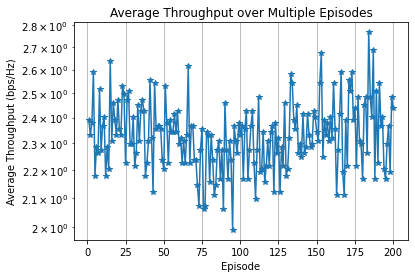

In [189]:
#Plotting average throughput over 100 episodes

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*')
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

plt.savefig('avg_throughput_all_episodes_200_episodes_10channels_800steps.png')

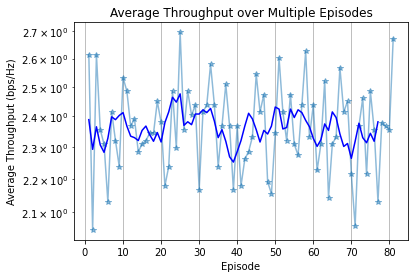

In [192]:
# import numpy as np
# import matplotlib.pyplot as plt

# Example data (replace this with your own data)
# episodes = np.arange(1, 101)  # episode numbers
# real_rewards = np.random.normal(0, 1, size=(100,))  # replace with your actual rewards

# Function to calculate a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size for smoothing
window_size = 5

# Calculate the moving average of real rewards
smoothed_rewards = moving_average(avg_reward_all_episodes, window_size)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*', alpha=0.5)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)


# Plot the original real rewards with reduced opacity
# plt.plot(episodes, real_rewards, label='Real Rewards', color='blue', alpha=0.5)

# Plot the smoothed rewards
plt.plot(all_epochs[:-window_size+1], smoothed_rewards, label=f'Smoothed Rewards (Window Size={window_size})', color='blue')

# Add labels and legend
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Average Reward vs Episode with Smoothed Rewards')
# plt.legend()

# Show the plot
# plt.show()

plt.savefig('Avg_Throughput_Round_Robinv2_800S_200E_2channels.png')


#### BD Battery State ####

In [126]:
E_B = np.zeros(nSteps)

for j in range(nSteps):
    P_T = 1 #AP transmission power: 1W
#     M = 10 #Jammer power level upper limit
#     P_J = np.random.randint(low=0,high=M,dtype = int) #choose a number between 1-4
    τ = 1 #e-3 #duration of 1 time slot = 1ms
    ξ = 0.8 #energy harvesting efficiency
    #levels = 5 #5 discrete levels of BD energy
    #E_levels = np.arange(1, levels+1, 1, dtype=int)
    n=-1
    (P_J,f_J,n) = Jammer(n)
    PR_J = Mean_Received_Jam_Power(P_J,f_J)
    U_E = ξ*(PR_J+P_T)*τ
#     U_E = ξ*((PR_J+(P_T*(APBD_ChannelGain(f_k))**2)))*τ#*E_levels #Unit Energy #Signal energy doesn't depend upon frequency
    E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
    E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
    E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
    E_B [j] = mu[j]*E_BC - (1 - mu[j])*E_EH + (1 - mu[j])*E_h + 1*U_E

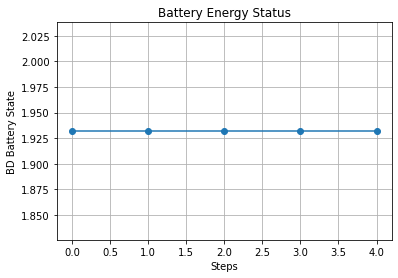

In [128]:
steps = np.arange(start = 0,stop=nSteps, step =1)
plt.plot(steps,E_B,'o-') 
plt.xlabel('Steps')
plt.ylabel('BD Battery State')
plt.title('Battery Energy Status')
plt.grid(True)
plt.show()

#plt.savefig('Bat_energy_status.png')

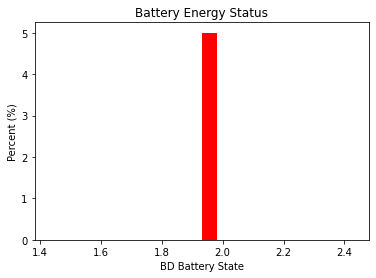

<Figure size 432x288 with 0 Axes>

In [129]:
# import numpy as np
# import matplotlib.pyplot as plt

# Generate an array of random values (replace this with your actual data)
# data = np.random.randn(400)

# Plot the histogram
plt.hist(E_B, bins=20, color = 'red')

# Add labels and title
plt.xlabel('BD Battery State')
plt.ylabel('Percent (%)')
plt.title('Battery Energy Status')

# Show the plot
plt.show()

#plt.savefig('BD_Bat_RR_400S_200E.png')

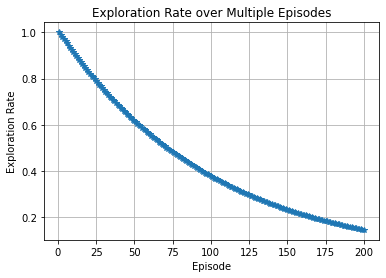

In [39]:
#Plotting exploration rate over multiple episodes

plt.plot(all_epochs,all_exploration_rate,'-*') 
plt.xlabel(r'Episode')
plt.ylabel(r'Exploration Rate')
plt.title('Exploration Rate over Multiple Episodes')
plt.grid(True)

#plt.savefig('exploration_rate.png')

### for debugging ###

In [29]:
f = 900e6
fJ = 900e6

# **** for path loss ****

# P_J = 20
# Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
# Gt_dBi = 1 #Gain of the Tx antenna in dBi 
# Gr_dBi = 1 #Gain of the Rx antenna in dBi
# d0 = 1 #reference distance of receiver from the transmitter in meters
# d = 10 # 
# dJ = 2 #distance between Tx and Rx
# L = 1 #Other System Losses, for no Loss case L=1
# sigma=2 #Standard deviation of log Normal distribution (in dB)
# n=2 #
# APBD_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
# jammer_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,fJ,d0,dJ,L,sigma,n)
# print('APBD Path Loss in dB: ',APBD_path_loss_dB)
# print('Jammer Path Loss in dB: ',jammer_path_loss_dB)

# **** for gain ****

H = APBD_ChannelGain(f)
JBD = JBD_ChannelGain(fJ)
JAP = JAP_ChannelGain(fJ)
print('AP - BD Channel Gain: ',H)
#print('AP - BD distance: ',d)
print('Jammer - AP Channel Gain: ',JAP)
print('Jammer - BD Channel Gain: ',JBD)
#print('Jammer - AP/BD Distance: ',dJ)

AP - BD Channel Gain:  8.358798669988254e-05
Jammer - AP Channel Gain:  0.00020574479287354197
Jammer - BD Channel Gain:  0.00015381176000592628


In [30]:
## Mean Jamming Power Received at AP ##
def Mean_Received_Jam_Power(P_J,f_J):
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    lambda_ = (3*10**8)/(f_J)
    d = 2 #distance between J and AP
    n=2 # path loss exponent
    PR_J = P_J*((Gt_dBi*Gr_dBi*(lambda_**2))/((d**n)*(4*np.pi)**2)) # in Watt
    return PR_J 

In [53]:
n = -1 
#Jammer Strategy: Static Jammer
(P_J,f_J,n) = Jammer(n)

k = 1 # AP channel 
f_k = Fc + (k*deltaf)
print('Jammer channel: ',f_J)
print('AP Channel: ',f_k)
#f_J = 930e6
        #reflection coefficient: s_bb = -1 for mu = 0=> non-reflecting state, s_bb = 1 for mu = 1=>reflecting state
# unwanted_signal = Mean_Received_Jam_Power(P_J,f_J) + loopback_Channel()*abs(x) + abs(complex_noise(0, 1, N*L))
# y_AP_squared = ((s_bb**2)*P_T*APBD_ChannelGain(f_k)*abs(x)) + ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*abs(x)*JBD_ChannelGain(f_J)*abs(x_J)) + loopback_Channel()*abs(x) + abs(complex_noise(0, 1, N*L))
#         #print(y_AP_squared[step])

P_R = ((s_bb**2)*P_T*(APBD_ChannelGain(f_k))**2) 
P_R_AP = sum(P_R)/(N*L) #Average Received Power
Noise_variance = (P_R_AP)/(10**(20/10)) #Desired SNR assumed to be 20dB
unwanted_signal = 1*(f_k == f_J)*P_J*JAP_ChannelGain(f_J) + loopback_Channel() + Noise_variance*abs(complex_noise(0, 1, N*L))
### 1*(f_k == f_J)*... => 0 if f_K is not equal to f_J
P_N = sum(unwanted_signal)/(N*L)
SNR =  P_R_AP/P_N
SNR_dB = 10*math.log(SNR)
# #print(SNR)
throughput = math.log2(1+SNR) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
# print(unwanted_signal)
# print(y_AP_squared)
# print('AP Channel: ',f_k)
# print('Jammer Channel: ',f_J)
print('Received Power: ',P_R_AP)
print('Noise Power: ',P_N)
print('SNR: ',SNR)
print('SNR in dB: ',SNR_dB)
print('Throughput: ',throughput)


Jammer channel:  900000000.0
AP Channel:  910000000.0
Received Power:  5.637356220925042e-10
Noise Power:  1.0156824805814774e-09
SNR:  0.5550313536665179
SNR in dB:  -5.887306737385521
Throughput:  0.63694366930969
